In [1]:
import numpy as np
import pandas as pd
import h5py
import os
import glob
from datetime import datetime
from datetime import timedelta
from matplotlib import pyplot as plt
import matplotlib.dates as md
import warnings
from scipy.interpolate import interp2d
from scipy.interpolate import interp1d
from scipy.interpolate import make_interp_spline
warnings.filterwarnings('ignore')
import scipy.ndimage as ndimage
from matplotlib import cm
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker
from sklearn import preprocessing
import seaborn as sns
from scipy.stats import pearsonr
from scipy import stats

In [3]:
def simple_read(path):
    with open(path) as f:
        first_line = f.readline()
        header_line = int(first_line[0:-2].split(",")[0])-1
        #all_lines = f.readlines()
    data = pd.read_csv(path, sep=',', skiprows=header_line)
    data.columns = [i.strip() for i in data.columns]
    #date = all_lines[5][0:10].split(',')
    #dt = datetime(int(date[0]), int(date[1]), int(date[2]))

    acc = 0
    boo = False
    for letter in path:
        if letter == '2':
            boo = True
        elif boo and letter == '0':
            acc -= 1
            break
        acc += 1
    #print(path[:acc+4], path[acc+4:acc+6], path[acc+6:acc+8])
    dt = datetime(int(path[acc:acc+4]), int(path[acc+4:acc+6]), int(path[acc+6:acc+8]))
    
    for column in data.keys():
        if 'Time' in column:
            data[column] = dt + pd.to_timedelta(data[column], unit='seconds')
    return data.replace(-999999, np.NaN)

In [8]:
DAY2= simple_read('C:/Users/taiwoajayi/Documents/Aeronet/BLH/activate-mrg1_hu25_20220602_RA_L1_20230331T150316.ict')
start_index = np.where(DAY2["Time_Start"]==pd.to_datetime("2022-06-02 13:48:00"))
stop_index = np.where(DAY2["Time_Start"]==pd.to_datetime("2022-06-02 14:10:00"))
    
DAY2_subset = DAY2[start_index[0][0]:stop_index[0][0]]
DAY2_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
8926,2022-06-02 13:48:00,2022-06-02 13:48:01,32.397719,-65.920473,1896.68,12.265,806.650,3.670,265.8606,10577.00,NaN,59.7,0.0,7.500,-0.285,0.675,0.540,NaN
8927,2022-06-02 13:48:01,2022-06-02 13:48:02,32.397400,-65.918900,1897.28,12.245,806.615,3.795,268.2852,10629.20,NaN,60.1,0.0,7.860,-0.305,0.655,0.535,NaN
8928,2022-06-02 13:48:02,2022-06-02 13:48:03,32.397079,-65.917327,1898.01,12.225,806.525,3.815,270.6952,10689.70,NaN,60.5,0.0,6.445,-0.050,1.000,0.580,NaN
8929,2022-06-02 13:48:03,2022-06-02 13:48:04,32.396758,-65.915754,1898.83,12.215,806.410,3.755,270.9941,10748.20,NaN,60.9,0.0,4.240,0.220,1.360,0.630,NaN
8930,2022-06-02 13:48:04,2022-06-02 13:48:05,32.396435,-65.914182,1899.75,12.200,806.305,3.720,269.8450,10752.00,NaN,60.9,0.0,3.630,-0.010,0.990,0.745,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10241,2022-06-02 14:09:55,2022-06-02 14:09:56,32.272869,-64.969777,2855.32,9.315,719.965,NaN,NaN,2491.56,NaN,15.3,0.0,6.495,-0.050,0.930,1.600,NaN
10242,2022-06-02 14:09:56,2022-06-02 14:09:57,32.273564,-64.970808,2861.28,9.295,719.475,NaN,NaN,2397.14,NaN,14.7,0.0,3.370,NaN,NaN,1.590,NaN
10243,2022-06-02 14:09:57,2022-06-02 14:09:58,32.274234,-64.971861,2867.15,9.260,718.840,NaN,NaN,2331.74,NaN,14.3,0.0,-1.400,NaN,NaN,1.605,NaN
10244,2022-06-02 14:09:58,2022-06-02 14:09:59,32.274877,-64.972937,2872.99,9.225,718.225,NaN,NaN,2289.79,NaN,14.1,0.0,-1.775,NaN,NaN,1.615,NaN


In [93]:
nbins = 20
bins = np.linspace(DAY2_subset.GPS_Altitude_THORNHILL.min(), DAY2_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY2_subset['Bins'] = pd.cut(DAY2_subset['GPS_Altitude_THORNHILL'], bins)
DAY2_subset_mean = DAY2_subset.groupby('Bins').mean()
DAY2_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,,,
"(106.28, 244.911]",2022-06-02 13:58:07.894366208,2022-06-02 13:58:08.894366208,32.213197,-65.047536,146.914190,23.602606,992.397148,NaN,NaN,24145.418310,NaN,82.195775,1.306400e-07,12.640106,0.293415,1.551514,1.236197,NaN
"(244.911, 383.542]",2022-06-02 13:58:08.000000000,2022-06-02 13:58:09.000000000,32.239811,-65.061946,304.594274,22.193548,974.281452,NaN,NaN,23446.135484,NaN,85.343548,1.547945e-07,12.644274,0.249355,1.454355,1.095000,NaN
"(383.542, 522.173]",2022-06-02 13:55:32.878661120,2022-06-02 13:55:33.878661120,32.277267,-65.256719,450.962385,20.989017,957.552259,6.094313,270.629543,22568.148954,NaN,86.906695,2.252253e-07,12.248305,0.309310,1.580690,1.198996,NaN
"(522.173, 660.804]",2022-06-02 13:57:55.937499904,2022-06-02 13:57:56.937499904,32.285202,-65.182251,578.473984,20.107109,943.598281,6.017609,267.157083,21384.517188,NaN,85.714062,1.345281e-07,11.327656,0.377344,1.753203,1.516172,NaN
"(660.804, 799.435]",2022-06-02 13:58:57.403508992,2022-06-02 13:58:58.403508736,32.260326,-65.158881,728.417368,19.310877,927.246754,5.763125,269.172213,20119.684211,NaN,83.222807,3.989432e-08,10.644386,0.371930,1.759386,1.317895,NaN
"(799.435, 938.066]",2022-06-02 13:57:48.857143040,2022-06-02 13:57:49.857143040,32.265234,-65.219000,861.595286,18.564571,912.859286,5.700000,266.176553,18441.454286,NaN,78.640000,2.447931e-08,8.993571,0.363857,1.714714,1.425714,NaN
"(938.066, 1076.697]",2022-06-02 13:59:05.756097536,2022-06-02 13:59:06.756097536,32.261414,-65.147942,1011.176829,17.678780,897.165976,5.367692,265.291138,17524.507317,NaN,77.758537,2.830549e-08,8.691585,0.365244,1.728171,1.355610,NaN
"(1076.697, 1215.328]",2022-06-02 13:59:31.209302272,2022-06-02 13:59:32.209302528,32.278911,-65.133786,1148.629070,17.025349,882.931512,5.654615,258.097454,15614.204651,NaN,71.034884,1.989935e-08,7.381395,0.333721,1.637907,1.199070,NaN
"(1215.328, 1353.959]",2022-06-02 14:00:12.250000128,2022-06-02 14:00:13.249999872,32.295780,-65.133350,1285.901667,16.060000,868.979688,5.430385,258.424369,14816.060417,NaN,70.566667,1.428137e-08,6.717396,0.337872,1.674043,1.394375,NaN


In [99]:
theta2 = (DAY2_subset_mean['Static_Air_Temp_THORNHILL']+273.15) * (1000 / DAY2_subset_mean['Static_Pressure_THORNHILL'])**(287/1004)
Theta2 = theta2-273
DAY2_subset_mean['Pot_temo'] = Theta2

In [100]:
es2 = 6.112 *np.exp((17.67 * DAY2_subset_mean['Static_Air_Temp_THORNHILL'])/(DAY2_subset_mean['Static_Air_Temp_THORNHILL'] + 243.5))
ea2 = (DAY2_subset_mean['RHw_DLH_DISKIN']/100) * es2
Td2 = (243.5 *np.log(ea2/6.112))/(17.67 - np.log(ea2/6.112))
Td2
DAY2_subset_mean['dewpoint'] = Td2

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


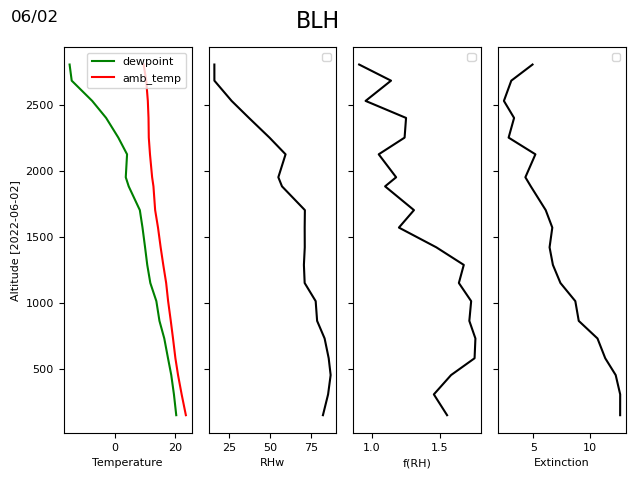

In [101]:
fig, ax = plt.subplots(1, 4, sharey='all')
plt.rcParams['font.size'] = '8'
ax[0].plot(DAY2_subset_mean['dewpoint'], DAY2_subset_mean['GPS_Altitude_THORNHILL'], color = "green", label = 'dewpoint')
ax[0].plot(DAY2_subset_mean['Static_Air_Temp_THORNHILL'], DAY2_subset_mean['GPS_Altitude_THORNHILL'], color = "red", label = 'amb_temp')
#ax[0].plot(Theta2, DAY2_subset_mean['GPS_Altitude_THORNHILL'], color = "Red", label = 'Temp')
ax[1].plot(DAY2_subset_mean['RHw_DLH_DISKIN'], DAY2_subset_mean['GPS_Altitude_THORNHILL'], color = "BLACK")
ax[2].plot(DAY2_subset_mean['fRH550_RH20to80_ZIEMBA'], DAY2_subset_mean['GPS_Altitude_THORNHILL'], color = "BLACK")
ax[3].plot(DAY2_subset_mean['Ext532_submicron_ZIEMBA'], DAY2_subset_mean['GPS_Altitude_THORNHILL'], color = "BLACK")
ax[0].set_ylabel('Altitude [2022-06-02]')
ax[0].set_xlabel('Temperature')
ax[1].set_xlabel('RHw')
ax[2].set_xlabel('f(RH)')
ax[3].set_xlabel('Extinction')
ax[0].legend(loc='upper right', fontsize=8)
ax[1].legend(loc='upper right', fontsize=8)
ax[2].legend(loc='upper right', fontsize=8)
ax[3].legend(loc='upper right', fontsize=8)
# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)
fig.text(0.02, 0.98, '06/02', ha='left', va='top', fontsize=12)

fig.suptitle('BLH', fontsize=16)
fig.tight_layout()
plt.show()

In [ ]:
DAY2= simple_read('C:/Users/taiwoajayi/Documents/Aeronet/BLH/activate-mrg1_hu25_20220602_RA_L1_20230331T150316.ict')
start_index = np.where(DAY2["Time_Start"]==pd.to_datetime("2022-06-02 13:48:00"))
stop_index = np.where(DAY2["Time_Start"]==pd.to_datetime("2022-06-02 14:10:00"))
    
DAY2_subset = DAY2[start_index[0][0]:stop_index[0][0]]
DAY2_subset

In [36]:
DAY7 = simple_read('C:/Users/taiwoajayi/Documents/Aeronet/BLH/activate-mrg1_hu25_20220607_RA_L1_20230331T150318.ict')
start_index = np.where(DAY7["Time_Start"]==pd.to_datetime("2022-06-07 14:32:00"))
stop_index = np.where(DAY7["Time_Start"]==pd.to_datetime("2022-06-07 14:47:00"))
    
DAY7_subset =DAY7[start_index[0][0]:stop_index[0][0]]
DAY7_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
10397,2022-06-07 14:32:00,2022-06-07 14:32:01,32.250498,-64.999220,127.595,21.705,1000.690,NaN,NaN,16839.20,NaN,64.8,2.102000e-07,21.970,0.225,1.380,0.540,NaN
10398,2022-06-07 14:32:01,2022-06-07 14:32:02,32.249883,-64.998233,126.585,21.705,1000.730,NaN,NaN,16797.70,NaN,64.7,6.026000e-08,23.210,0.225,1.380,0.535,NaN
10399,2022-06-07 14:32:02,2022-06-07 14:32:03,32.249267,-64.997244,125.870,21.700,1000.550,NaN,NaN,16749.30,NaN,64.5,1.223000e-07,22.465,0.220,1.370,0.530,NaN
10400,2022-06-07 14:32:03,2022-06-07 14:32:04,32.248648,-64.996254,125.955,21.735,1000.850,NaN,NaN,16872.70,NaN,65.0,8.455000e-08,22.830,0.110,1.170,0.525,NaN
10401,2022-06-07 14:32:04,2022-06-07 14:32:05,32.248027,-64.995263,126.990,21.755,1001.140,NaN,NaN,16893.50,NaN,64.9,2.812000e-07,22.345,0.155,1.245,0.525,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11292,2022-06-07 14:46:55,2022-06-07 14:46:56,32.255021,-64.999573,2800.660,9.430,728.710,NaN,NaN,4644.94,NaN,28.6,0.000000e+00,NaN,NaN,NaN,NaN,NaN
11293,2022-06-07 14:46:56,2022-06-07 14:46:57,32.255098,-64.998248,2805.770,9.405,728.240,NaN,NaN,4638.46,NaN,28.6,0.000000e+00,NaN,NaN,NaN,NaN,NaN
11294,2022-06-07 14:46:57,2022-06-07 14:46:58,32.255152,-64.996919,2810.920,9.380,727.790,NaN,NaN,4632.07,NaN,28.6,0.000000e+00,NaN,NaN,NaN,NaN,NaN
11295,2022-06-07 14:46:58,2022-06-07 14:46:59,32.255184,-64.995588,2816.140,9.355,727.350,NaN,NaN,4619.24,NaN,28.6,0.000000e+00,NaN,NaN,NaN,NaN,NaN


In [89]:
nbins = 20
bins = np.linspace(DAY7_subset.GPS_Altitude_THORNHILL.min(), DAY7_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY7_subset['Bins'] = pd.cut(DAY7_subset['GPS_Altitude_THORNHILL'], bins)
DAY7_subset_mean = DAY7_subset.groupby('Bins').mean()
DAY7_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Static_Air_Temp_THORNHILL,Static_Pressure_THORNHILL,Wind_Speed_THORNHILL,Wind_Direction_THORNHILL,H2O_DLH_DISKIN,RHi_DLH_DISKIN,RHw_DLH_DISKIN,LWC_FCDP_VOIGT,Ext532_submicron_ZIEMBA,gamma550_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscat_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,,,
"(125.87, 260.648]",2022-06-07 14:32:26.962264064,2022-06-07 14:32:27.962264320,32.228359,-64.980091,191.982925,21.169245,993.448302,NaN,NaN,16718.416981,NaN,66.047170,2.693672e-07,21.920189,0.265566,1.467736,0.718113,NaN
"(260.648, 395.426]",2022-06-07 14:33:22.500000000,2022-06-07 14:33:23.500000000,32.184684,-65.002125,320.002672,20.000862,978.874397,NaN,NaN,16645.025862,NaN,69.636207,2.639698e-07,21.826293,0.259914,1.458879,0.693793,NaN
"(395.426, 530.204]",2022-06-07 14:34:19.000000256,2022-06-07 14:34:20.000000000,32.207508,-65.045768,461.442818,18.577000,962.903909,NaN,NaN,16627.980000,NaN,74.769091,2.293664e-07,21.443273,0.275091,1.480818,0.681273,NaN
"(530.204, 664.982]",2022-06-07 14:35:16.500000000,2022-06-07 14:35:17.500000000,32.232658,-65.008332,595.978500,17.307167,947.990833,NaN,NaN,16533.116667,NaN,79.296667,3.925132e-07,23.147333,0.248083,1.430167,0.655917,NaN
"(664.982, 799.76]",2022-06-07 14:36:14.500000000,2022-06-07 14:36:15.500000000,32.190803,-64.988014,732.742768,16.177232,932.943839,NaN,NaN,15968.450000,NaN,80.935714,3.291282e-07,22.142232,0.275000,1.479554,0.670536,NaN
"(799.76, 934.538]",2022-06-07 14:37:10.000000000,2022-06-07 14:37:11.000000000,32.178847,-65.039683,867.218273,15.368545,918.043545,NaN,NaN,13890.792727,NaN,72.981818,1.572545e-07,18.001273,0.285273,1.514273,0.894000,NaN
"(934.538, 1069.316]",2022-06-07 14:38:02.000000256,2022-06-07 14:38:03.000000000,32.219780,-65.062597,1000.849694,14.718571,903.397449,NaN,NaN,12590.128571,NaN,67.900000,1.060361e-07,15.417347,0.295408,1.538980,0.987143,NaN
"(1069.316, 1204.094]",2022-06-07 14:38:51.000000000,2022-06-07 14:38:52.000000000,32.251072,-65.030295,1134.863673,14.140306,889.464388,NaN,NaN,13464.965306,NaN,74.208163,9.536310e-08,17.051224,0.344592,1.641939,0.751327,NaN
"(1204.094, 1338.872]",2022-06-07 14:39:37.000000000,2022-06-07 14:39:38.000000000,32.231774,-64.988403,1270.812093,13.827209,875.303023,NaN,NaN,10080.367209,NaN,56.181395,2.551788e-08,13.336395,0.305465,1.568023,0.726744,NaN


In [102]:
theta7 = (DAY7_subset_mean['Static_Air_Temp_THORNHILL']+273.15) * (1000 / DAY7_subset_mean['Static_Pressure_THORNHILL'])**(287/1004)
Theta7 = theta7-273
Theta7
DAY7_subset_mean['Pot_temo'] = Theta7

In [103]:
es7 = 6.112 *np.exp((17.67 * DAY7_subset_mean['Static_Air_Temp_THORNHILL'])/(DAY7_subset_mean['Static_Air_Temp_THORNHILL'] + 243.5))
ea7 = (DAY7_subset_mean['RHw_DLH_DISKIN']/100) * es7
Td7 = (243.5 *np.log(ea7/6.112))/(17.67 - np.log(ea7/6.112))
Td7
DAY7_subset_mean['dewpoint'] = Td7

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


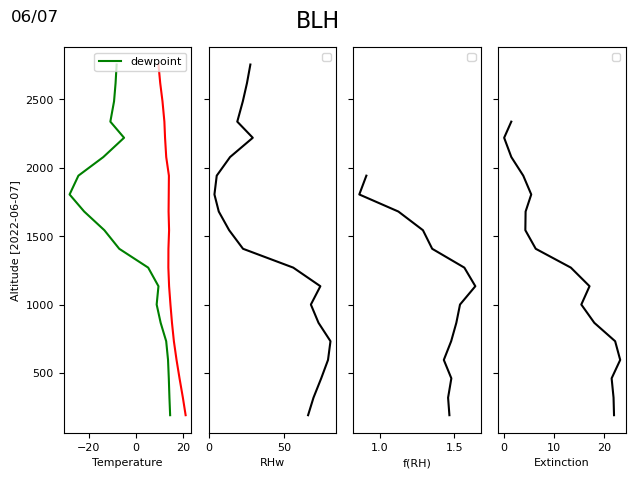

In [104]:
fig, ax = plt.subplots(1, 4, sharey='all')
plt.rcParams['font.size'] = '8'
ax[0].plot(DAY7_subset_mean['dewpoint'], DAY7_subset_mean['GPS_Altitude_THORNHILL'], color = "green", label = 'dewpoint')
ax[0].plot(DAY7_subset_mean['Static_Air_Temp_THORNHILL'], DAY7_subset_mean['GPS_Altitude_THORNHILL'], color = "red")
#ax[0].plot(Theta7, DAY2_subset_mean['GPS_Altitude_THORNHILL'], color = "Red", label = 'Temp')
ax[1].plot(DAY7_subset_mean['RHw_DLH_DISKIN'], DAY7_subset_mean['GPS_Altitude_THORNHILL'], color = "BLACK")
ax[2].plot(DAY7_subset_mean['fRH550_RH20to80_ZIEMBA'], DAY7_subset_mean['GPS_Altitude_THORNHILL'], color = "BLACK")
ax[3].plot(DAY7_subset_mean['Ext532_submicron_ZIEMBA'], DAY7_subset_mean['GPS_Altitude_THORNHILL'], color = "BLACK")
ax[0].set_ylabel('Altitude [2022-06-07]')
ax[0].set_xlabel('Temperature')
ax[1].set_xlabel('RHw')
ax[2].set_xlabel('f(RH)')
ax[3].set_xlabel('Extinction')
ax[0].legend(loc='upper right', fontsize=8)
ax[1].legend(loc='upper right', fontsize=8)
ax[2].legend(loc='upper right', fontsize=8)
ax[3].legend(loc='upper right', fontsize=8)
# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)
fig.text(0.02, 0.98, '06/07', ha='left', va='top', fontsize=12)

fig.suptitle('BLH', fontsize=16)
fig.tight_layout()
plt.show()

In [81]:
DAY77 = simple_read('C:/Users/taiwoajayi/Documents/HSRL_MLH/ACTIVATE-HSRL2-mlh_KINGAIR_20220607_R0_L1.ict')
DAY77.replace(-9999, np.NaN)

,Time_Start,Time_Stop,Time_Mid,Latitude,Longitude,GPS_Altitude,DEM_altitude,MLH,MLH_qa,Avg_532bsc_sfc300m,Avg_532bsc_sfc_to_mlh,Avg_532bsc_500m_abv_mlh,Avg_532ext_sfc300m,Avg_532ext_sfc_to_mlh,Avg_532ext_500m_abv_mlh
0,2022-06-07 11:15:33,2022-06-07 11:15:42,2022-06-07 11:15:37.500,32.363,-64.665,2.94,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-06-07 11:15:43,2022-06-07 11:15:52,2022-06-07 11:15:47.500,32.363,-64.665,2.81,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-06-07 11:15:53,2022-06-07 11:16:02,2022-06-07 11:15:57.500,32.363,-64.664,2.63,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-06-07 11:16:03,2022-06-07 11:16:12,2022-06-07 11:16:07.500,32.363,-64.663,1.57,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-06-07 11:16:13,2022-06-07 11:16:22,2022-06-07 11:16:17.500,32.362,-64.663,1.07,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,2022-06-07 14:44:20,2022-06-07 14:44:30,2022-06-07 14:44:25.000,32.217,-65.001,4207.11,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1246,2022-06-07 14:44:31,2022-06-07 14:44:40,2022-06-07 14:44:35.500,32.213,-64.985,4096.07,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1247,2022-06-07 14:44:41,2022-06-07 14:44:50,2022-06-07 14:44:45.500,32.210,-64.971,3993.00,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1248,2022-06-07 14:44:51,2022-06-07 14:45:00,2022-06-07 14:44:55.500,32.206,-64.957,3888.37,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
nbins = 15
bins = np.linspace(DAY77.GPS_Altitude.min(), DAY77.GPS_Altitude.max(), nbins+1)
DAY77['Bins'] = pd.cut(DAY77['GPS_Altitude'], bins)
DAY7_mean = DAY77.groupby('Bins').mean()
DAY7_mean = DAY7_mean.replace(-9999, np.NaN)

In [86]:
start_altitude = 100
stop_altitude = 3000

start_index = np.where(DAY7_mean["GPS_Altitude"] >= start_altitude)[0][0]
stop_index = np.where(DAY7_mean["GPS_Altitude"] <= stop_altitude)[0][-1]

DAY7_subset7 = DAY7_mean[start_index:stop_index+1]
DAY7_subset7


,Time_Start,Time_Stop,Time_Mid,Latitude,Longitude,GPS_Altitude,DEM_altitude,MLH,MLH_qa,Avg_532bsc_sfc300m,Avg_532bsc_sfc_to_mlh,Avg_532bsc_500m_abv_mlh,Avg_532ext_sfc300m,Avg_532ext_sfc_to_mlh,Avg_532ext_500m_abv_mlh
Bins,,,,,,,,,,,,,,,
"(0.15, 599.463]",2022-06-07 11:20:47.090909184,2022-06-07 11:20:56.045454592,2022-06-07 11:20:51.568181760,32.475364,-64.523636,103.763182,3.545455,NaN,NaN,NaN,NaN,NaN,-9544.497955,NaN,NaN
"(599.463, 1198.775]",2022-06-07 11:19:37.666666496,2022-06-07 11:19:46.833333248,2022-06-07 11:19:42.250000128,32.380167,-64.765667,930.866667,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(1198.775, 1798.088]",2022-06-07 11:20:42.857142784,2022-06-07 11:20:51.857143040,2022-06-07 11:20:47.357142784,32.367571,-64.821714,1541.998571,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(1798.088, 2397.401]",2022-06-07 11:21:57.875000064,2022-06-07 11:22:06.875000064,2022-06-07 11:22:02.375000064,32.354125,-64.887625,2128.036250,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(2397.401, 2996.713]",2022-06-07 11:23:27.800000000,2022-06-07 11:23:36.800000000,2022-06-07 11:23:32.300000000,32.325500,-64.965300,2697.023000,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
'''start_time = pd.to_datetime("2022-06-07 14:30:20")
stop_time = pd.to_datetime("2022-06-07 14:45:01")

# Find the indices of start and stop times
start_index = np.where(DAY77["Time_Start"] >= start_time)[0]
stop_index = np.where(DAY77["Time_Start"] <= stop_time)[0]

# Check if the indices are within bounds
if len(start_index) > 0 and len(stop_index) > 0:
    DAY7_subset7 = DAY77[start_index[0]:stop_index[-1]+1]
    print(DAY7_subset7)
else:
    print("No data found within the specified datetime range.")'''



'start_time = pd.to_datetime("2022-06-07 14:30:20")\nstop_time = pd.to_datetime("2022-06-07 14:45:01")\n\n# Find the indices of start and stop times\nstart_index = np.where(DAY77["Time_Start"] >= start_time)[0]\nstop_index = np.where(DAY77["Time_Start"] <= stop_time)[0]\n\n# Check if the indices are within bounds\nif len(start_index) > 0 and len(stop_index) > 0:\n    DAY7_subset7 = DAY77[start_index[0]:stop_index[-1]+1]\n    print(DAY7_subset7)\nelse:\n    print("No data found within the specified datetime range.")'

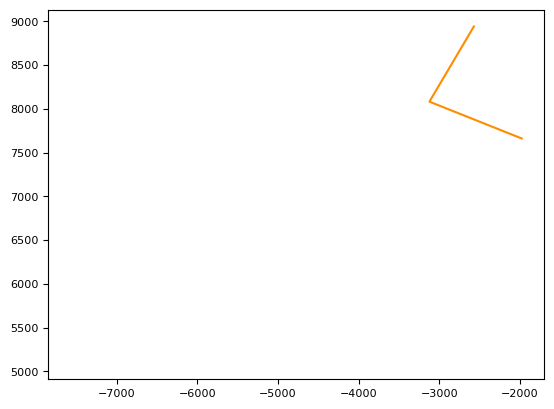

In [88]:
fig, ax = plt.subplots()
ax.plot(DAY7_mean['MLH'], DAY7_mean['GPS_Altitude'], color="darkorange", label="MLH")